In [1]:
import os
if os.getcwd().split("/")[-1] != 'BENDR-XAI': os.chdir("../")

import mne
import numpy as np
import matplotlib.pyplot as plt
from utils import *

from matplotlib import animation
import matplotlib.cm as cm
import sys
from tqdm import tqdm

## Test

In [2]:
edf_file_path = 'notebooks/S001R10.edf'

/home/andersgm/anaconda3/envs/XAI/lib/python3.10/site-packages/mne/viz/utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


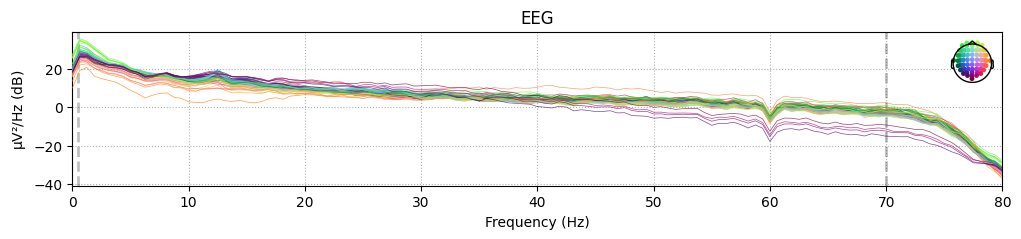

In [3]:
subjects_dir, subject, trans, src_path, bem_path = get_fsaverage()
raw = get_raw(edf_file_path)

fig, ax = plt.subplots(1, 1, figsize=(12, 2))
raw.compute_psd(verbose = False).plot(axes = ax)
plt.show()

In [4]:
fwd = get_fwd(raw.info, trans, src_path, bem_path)
cov = get_cov(raw)

In [5]:
stc = get_stc(raw, fwd, cov)

In [27]:
mne.datasets.fetch_hcp_mmp_parcellation(subjects_dir=subjects_dir, accept=True)
labels_lh = mne.read_labels_from_annot('fsaverage', 'HCPMMP1', 'lh', subjects_dir=subjects_dir, verbose=False)
labels_rh = mne.read_labels_from_annot('fsaverage', 'HCPMMP1', 'lh', subjects_dir=subjects_dir, verbose=False)
labels = [labels_lh, labels_rh]

labels_combined_lh = mne.read_labels_from_annot('fsaverage', 'HCPMMP1_combined', 'lh', subjects_dir=subjects_dir, verbose=False)
labels_combined_rh = mne.read_labels_from_annot('fsaverage', 'HCPMMP1_combined', 'rh', subjects_dir=subjects_dir, verbose=False)
labels_combined = [labels_lh, labels_rh]

In [6]:
src = get_src(src_path)

In [19]:
vertices = get_vertices(src)
tris_vertices = get_vertices_tris(src)

sources = get_sources(src)
tris_sources = get_sources_tris(src)

In [148]:
tris_values = get_z_values(sources, tris_sources)
tris_colors = cm.viridis(tris_values)

for hemi_idx in range(2):
    for i in tqdm(range(len(labels[hemi_idx]))):
        region_source_indices = labels[hemi_idx][i].get_vertices_used()
        region_tris_indices = get_tris_idx(region_source_indices, tris_sources[hemi_idx])
        tris_colors[hemi_idx][region_tris_indices] = np.array(cm.tab20(i / len(labels[hemi_idx])))

100%|██████████| 181/181 [00:34<00:00,  5.26it/s]


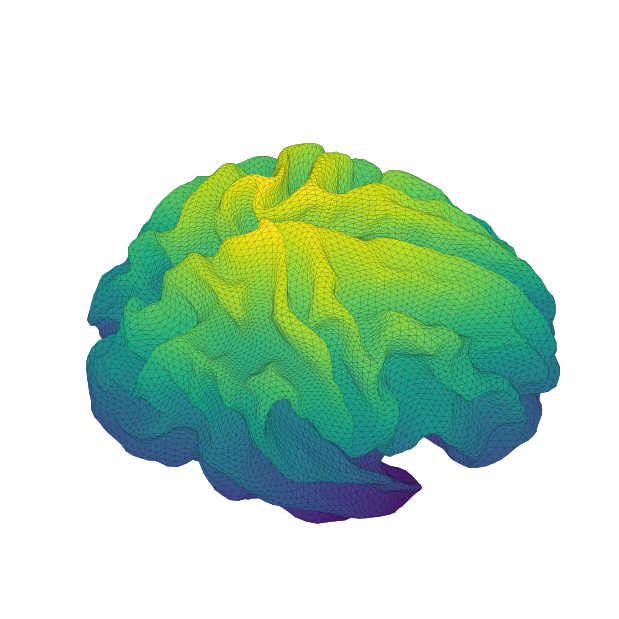

In [232]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1, 1, 1, projection='3d')

for i in range(2):
    mesh = ax.plot_trisurf(*sources[i].T, triangles=tris_sources[i], linewidth=0.1, shade=False,
                            antialiased=True, edgecolor=(0,0,0,0.5), cmap="viridis")

    mesh.set_facecolors(tris_colors[i])

ax.set_xlim(-0.06, 0.06)
ax.set_ylim(-0.08, 0.04)
ax.set_zlim(-0.04, 0.09)
ax.set_box_aspect([1,1,1])
ax.view_init(45, 360)
ax.axis("off")
fig.subplots_adjust(left=0, right=1, bottom=0, top=1)

plt.show()

In [265]:
activity_lh = np.empty(len(labels_combined_lh))

for i in range(len(labels_combined_lh)):
    activity_lh[i] = np.abs(stc.in_label(labels_combined_lh[i]).data).sum()

activity_rh = np.empty(len(labels_combined_rh))

for i in range(len(labels_combined_rh)):
    activity_rh[i] = np.abs(stc.in_label(labels_combined_rh[i]).data).sum()


min_act = np.min((activity_lh, activity_rh))
max_act = np.max((activity_lh, activity_rh))

activity_lh = (activity_lh - min_act) / (max_act - min_act)
activity_rh = (activity_rh - min_act) / (max_act - min_act)

In [266]:
values = np.zeros(len(vertices))

In [267]:
for i in range(len(labels_combined_lh)):
    values[labels_combined_lh[i].vertices + int(len(vertices) / 2)] = activity_lh[i]

for i in range(len(labels_combined_rh)):
    values[labels_combined_rh[i].vertices] = activity_rh[i]

In [277]:
vertices_down, triangles_down, color_down = decimate_mesh(vertices, triangles, values, reduction=0.90, verbose=False)

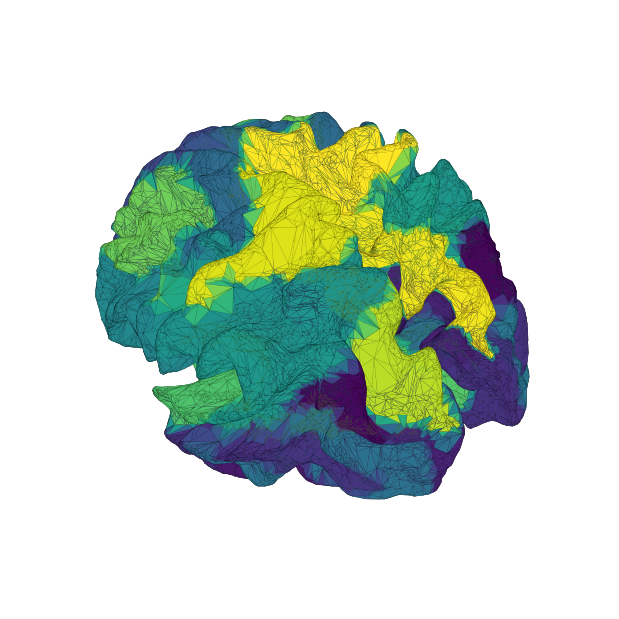

In [278]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1, 1, 1, projection='3d')

mesh = ax.plot_trisurf(*vertices_down.T, triangles=triangles_down, linewidth=0.1, shade=False,
                        antialiased=True, edgecolor=(0,0,0,0.5)) #, cmap="viridus")


facecolor = np.empty(len(triangles_down))

for i, (a, b, c) in enumerate(triangles_down):
    facecolor[i] = np.mean(color_down[[a,b,c]])

mesh.set_facecolors(cm.viridis(facecolor))

ax.set_xlim(-0.06, 0.06)
ax.set_ylim(-0.05, 0.07)
ax.set_zlim(-0.01, 0.11)
ax.set_box_aspect([1,1,1])

ax.view_init(45, 45+180)

ax.axis("off")

fig.subplots_adjust(left=0, right=1, bottom=0, top=1)

plt.show()